# Student Performance Regression
This project aims to predict students' exam scores using lifestyle and academic related features.

## TO RUN THIS FILE, CLICK ON THE LINK TO RUN FROM GOOGLE COLAB

https://colab.research.google.com/drive/13shvctdDFHpLJl-ZdWY4gB6xbhG6FRpt?usp=sharing

## Download

In [1]:
import kagglehub

path = kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/student-habits-vs-academic-performance


## Install

In [2]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


## Import

In [3]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber
from sklearn.decomposition import PCA
from keras.layers import Input

## Reading data

In [4]:
df = pd.read_csv("/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv")

#df.head()

display(df.head(5))

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


## Data Visualization

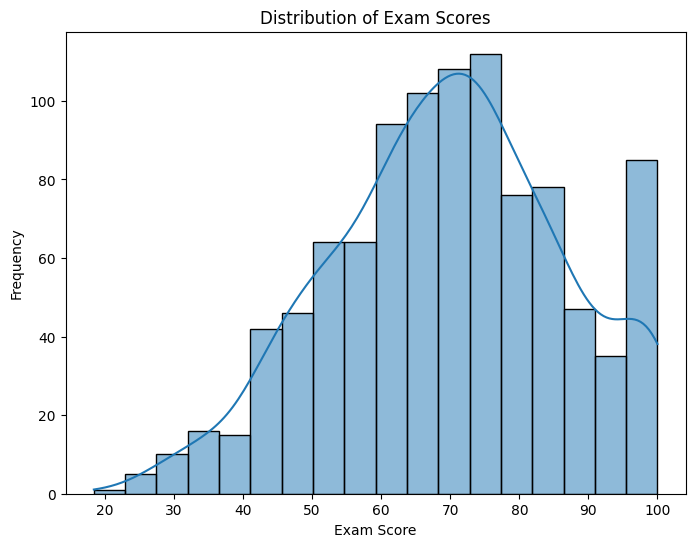

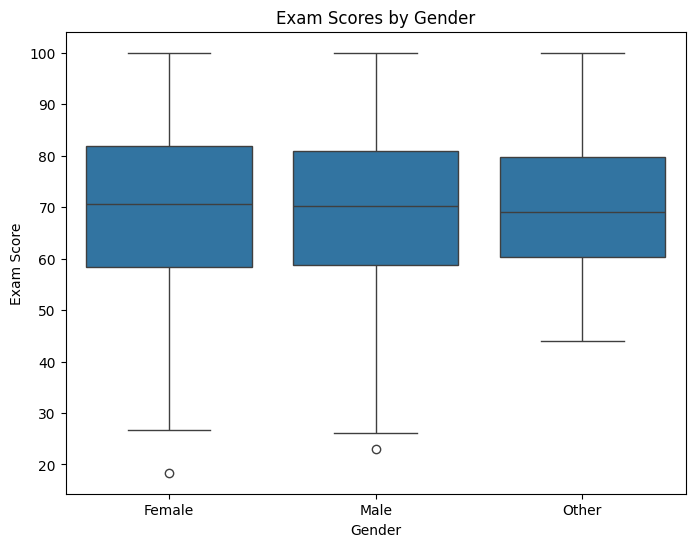

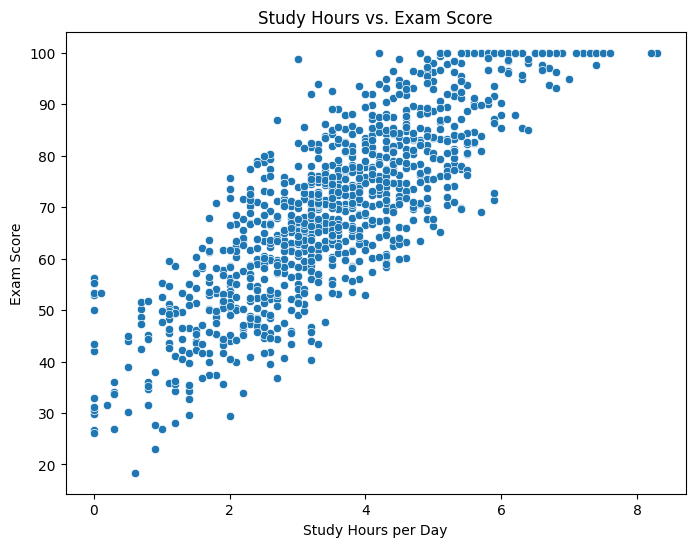

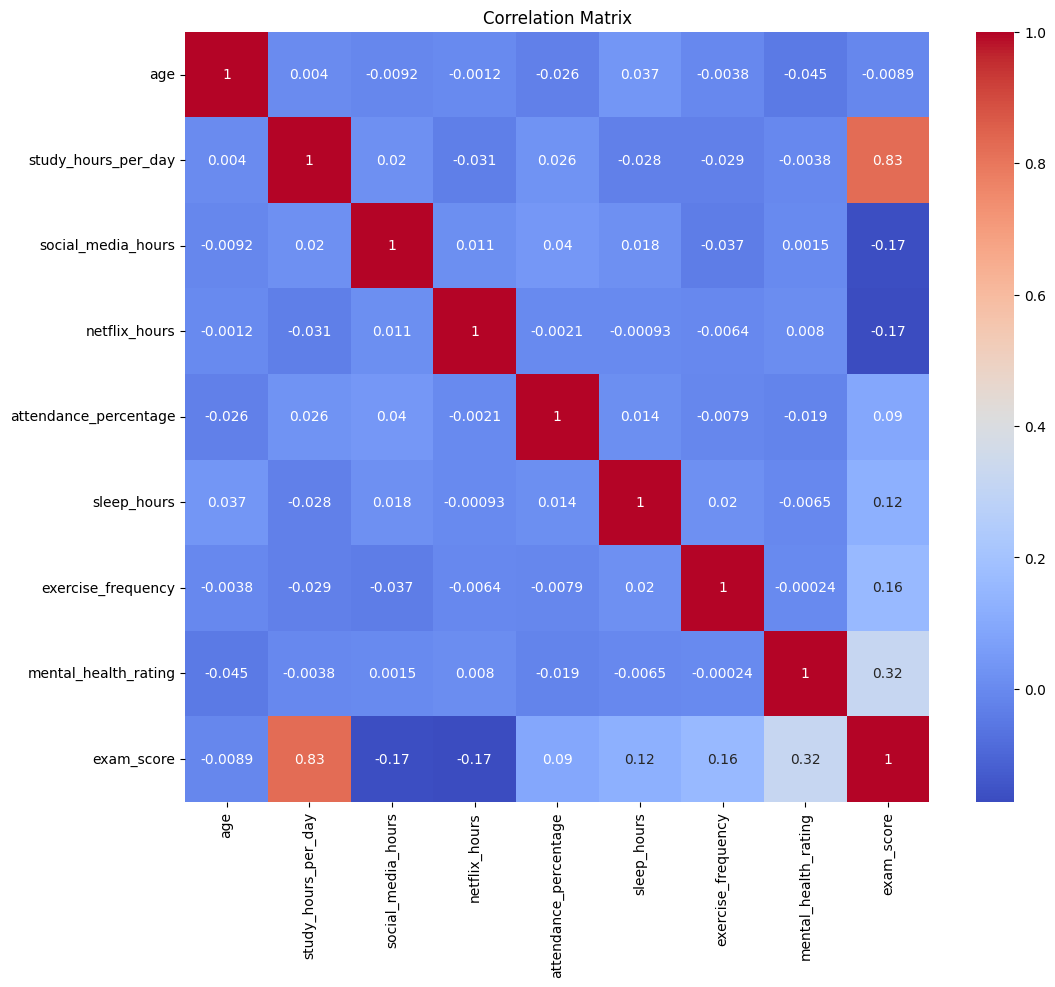

In [5]:
#Exam scores Visualisation
numerical_features = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.histplot(df['exam_score'], kde=True)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()

#Gender and exam score
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='exam_score', data=df)
plt.title('Exam Scores by Gender')
plt.xlabel('Gender')
plt.ylabel('Exam Score')
plt.show()

#Study hours and exam score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='study_hours_per_day', y='exam_score', data=df)
plt.title('Study Hours vs. Exam Score')
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')
plt.show()

#Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Preprocessing

### Drop 'student_id' and 'exam_score' column

In [6]:
# Drop student_ID column
df = df.drop(columns=['student_id'])

X = df.drop(columns=['exam_score']) #features
y = df['exam_score'] #target

### Non Numerical Feature Conversion and Standardization

In [7]:
categorical_features = [
    'gender',
    'part_time_job',
    'parental_education_level',
    'extracurricular_participation',
    'diet_quality',
    'internet_quality'
]

numerical_features = [col for col in X.columns if col not in categorical_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

X_transformed = preprocessor.fit_transform(X)

cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                                columns=all_feature_names)

# Show final preprocessed dataset
X_transformed_df.head()



,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,gender_Male,gender_Other,part_time_job_Yes,parental_education_level_High School,parental_education_level_Master,parental_education_level_nan,extracurricular_participation_Yes,diet_quality_Good,diet_quality_Poor,internet_quality_Good,internet_quality_Poor
0,1.084551,-2.418068,-1.114064,-0.669750,0.092426,1.248120,1.461166,0.900186,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.215870,2.281707,0.251315,0.446965,1.401696,-1.525661,1.461166,0.900186,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.217604,-1.464491,0.507324,-0.483631,1.135584,1.248120,-1.008689,-1.559339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.084551,-1.736942,1.190013,-0.762810,-1.397800,2.227102,0.473224,-1.559339,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.649344,0.987566,1.616694,-1.228108,0.720450,-1.280916,-0.020747,-1.559339,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Split dataset

In [8]:
# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Linear Regression

### Training Model

In [9]:
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

y_pred_linear_reg = linear_reg.predict(X_test_transformed)

mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)
mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
r2_linear_reg = r2_score(y_test, y_pred_linear_reg)

print("Results:")
print(f"  MAE: {mae_linear_reg:.4f}")
print(f"  MSE: {mse_linear_reg:.4f}")
print(f"  R-squared (R2): {r2_linear_reg:.4f}")


Results:
  MAE: 4.2227
  MSE: 28.9396
  R-squared (R2): 0.8971


### Plot

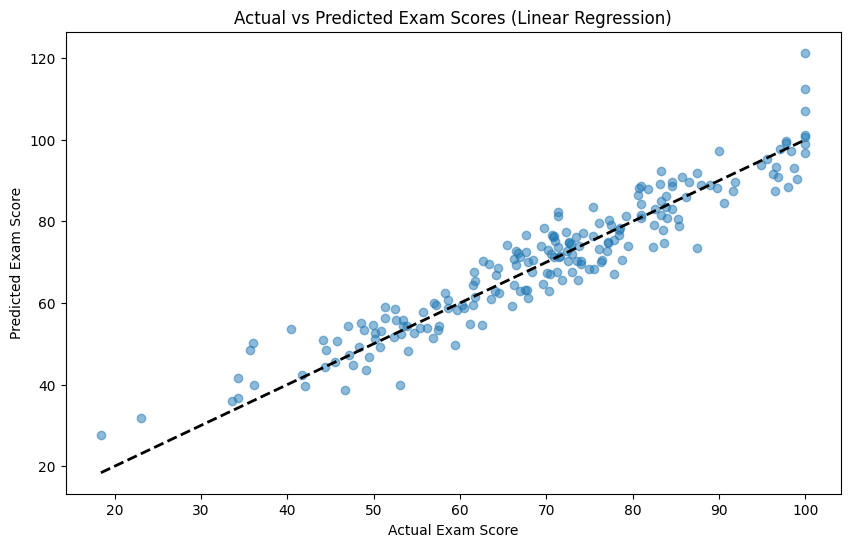

In [10]:
#predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear_reg, alpha=0.5)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores (Linear Regression)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Diagonal line
plt.show()

## Random Forest Model

### Training

In [11]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_transformed, y_train)

y_pred_rf = rf_model.predict(X_test_transformed)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print(f"  MAE: {mae_rf:.4f}")
print(f"  MSE: {mse_rf:.4f}")
print(f"  R-squared (R2): {r2_rf:.4f}")

Random Forest Regression Results:
  MAE: 4.6980
  MSE: 37.2946
  R-squared (R2): 0.8674


### Plot

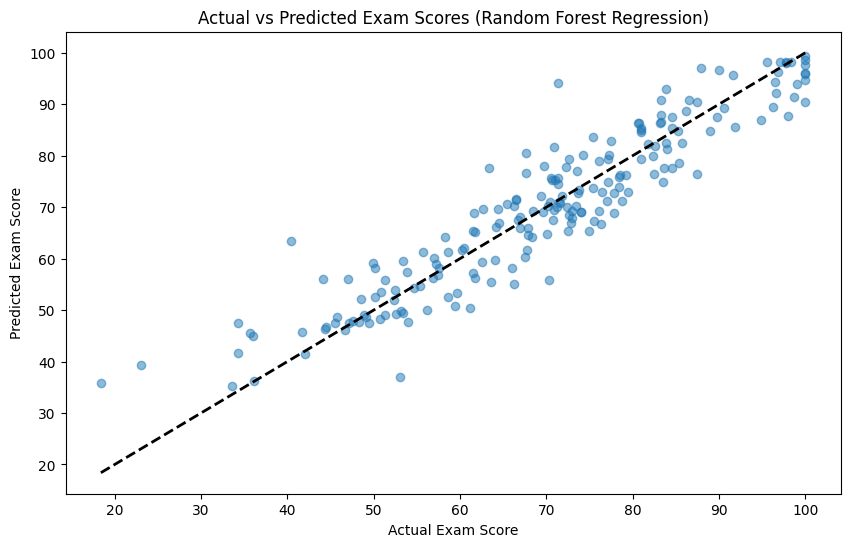

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores (Random Forest Regression)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Diagonal line
plt.show()

## XGBoost Model

### Training

In [13]:
dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
dval = xgb.DMatrix(X_val_transformed, label=y_val)
dtest = xgb.DMatrix(X_test_transformed, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_rounds = 100
watchlist = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)

y_pred_xgb = xgb_model.predict(dtest)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Results:")
print(f"  MAE: {mae_xgb:.4f}")
print(f"  MSE: {mse_xgb:.4f}")
print(f"  R-squared (R2): {r2_xgb:.4f}")

XGBoost Regression Results:
  MAE: 4.1740
  MSE: 27.7109
  R-squared (R2): 0.9015


### Plot

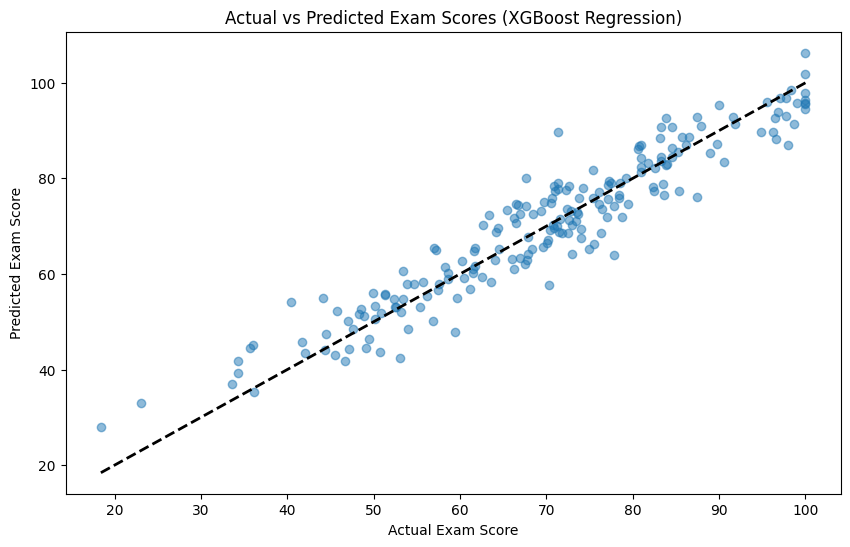

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores (XGBoost Regression)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Diagonal line
plt.show()

## Multilayer Perceptron Model

### Training

In [15]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]
model = Sequential([
    Dense(128, activation='sigmoid', input_dim=input_dim),
    Dropout(0.4),  # increased dropout for stronger regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # output for regression
])

# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=200,
    batch_size=32,  # adjusted for efficiency
    callbacks=[early_stop, checkpoint],
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)
model.save("final_model.keras")  # Save in native format
print(f"\nTest MAE: {test_mae:.3f}, Test MSE: {test_loss:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 70.5602 - mae: 71.0602
Epoch 1: val_loss improved from inf to 61.73645, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 68.9172 - mae: 69.4172 - val_loss: 61.7365 - val_mae: 62.2365
Epoch 2/200
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60.0473 - mae: 60.5473  
Epoch 2: val_loss improved from 61.73645 to 51.51019, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 59.2573 - mae: 59.7573 - val_loss: 51.5102 - val_mae: 52.0102
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 48.5312 - mae: 49.0309
Epoch 3: val_loss improved from 51.51019 to 37.19057, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 48.3871 - mae: 48.8867 - val_loss: 37.1906 - val_mae: 37.6906
Epoch 4/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.2398 - mae: 34.7378
Epoch 4: val_loss improved from 37.19057 to 20.84494, saving model to best_model.ke

### Plot

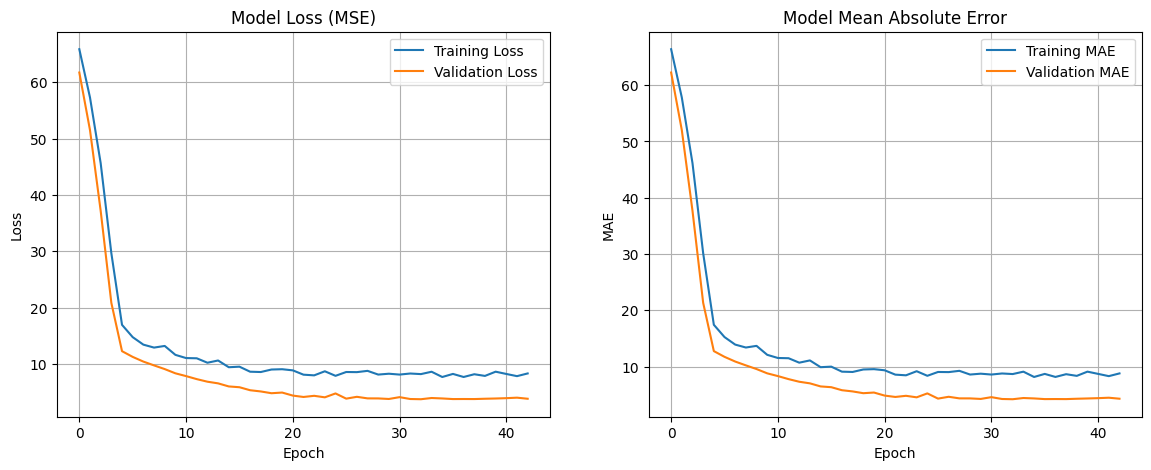

In [16]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

### Interpretability: Random Forest

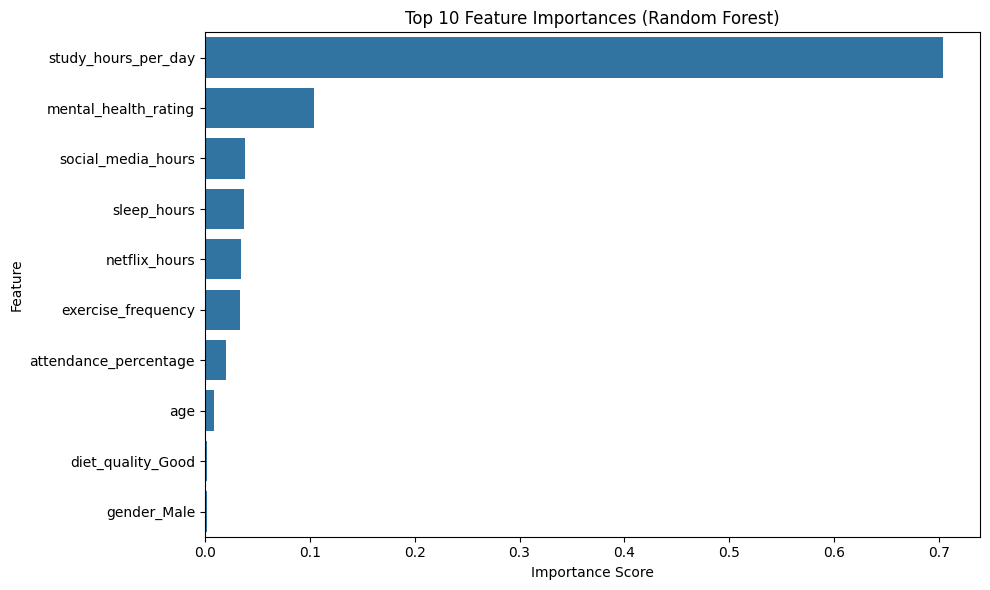

In [17]:
# Train Random Forest on full data (for interpretability)
X_all_processed = preprocessor.fit_transform(X)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_all_processed, y)

# Get feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

# Plot top features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:top_n], y=np.array(all_feature_names)[indices][:top_n])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Principal Component Analysis (PCA)

In [18]:
pca = PCA(n_components=None) # Set number of components
pca_data = pca.fit_transform(X_transformed_df)

# Convert to DataFrame for clarity (optional)
pca_df = pd.DataFrame(pca_data)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-2.739648,0.474051,0.916796,1.224677,0.749673,-0.578613,-0.677377,1.280739,0.190161,-0.749482,-0.195901,-0.557692,0.505382,-0.016882,0.606097,-0.486640,-0.539863,0.221278,-0.100462
1,1.504194,-1.135307,-0.685199,1.098671,-0.736853,2.559054,0.398967,0.695787,-0.129425,0.617983,0.198391,-0.686909,-0.293560,-0.163096,0.210591,0.225816,-0.309253,0.024507,-0.076066
2,0.294390,1.873532,1.061903,0.345974,-0.473953,-1.897769,-0.514596,0.065989,-1.231828,-0.019687,0.288180,0.452960,-0.318914,-0.360156,0.209203,0.426640,0.560278,-0.003437,-0.027649
3,-1.651688,2.591852,0.979429,-0.046353,0.996199,-1.531967,1.414090,-0.612237,0.587822,-1.002401,0.281613,-0.110789,0.649934,-0.079251,0.592199,0.331620,0.103836,0.119549,-0.137078
4,2.131671,0.491927,-1.055209,0.644360,-0.937454,-0.699215,1.624308,-0.009703,0.819916,-0.576688,-0.023493,-0.079084,-0.285045,-0.135757,0.537060,-0.341703,-0.026855,0.095754,-0.070778


### Explained Varience of Each component

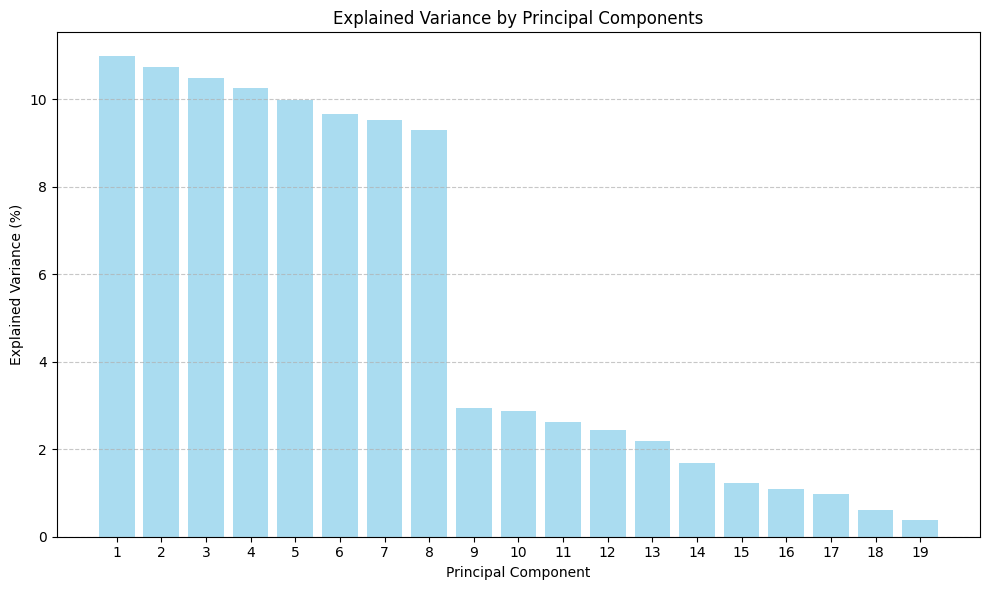

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_ * 100,
    alpha=0.7,
    color='skyblue'
)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### PCA Explained Variance

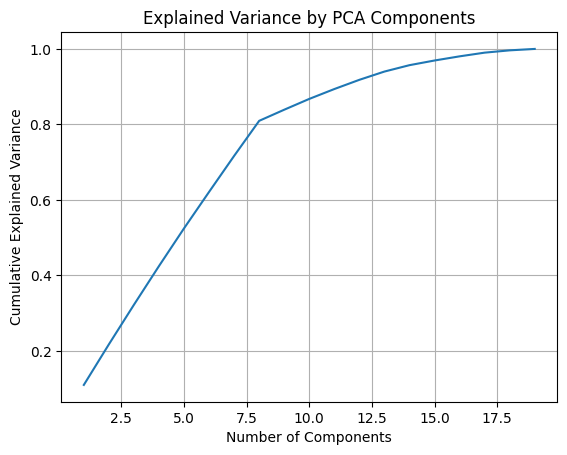

In [20]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


### MLP with PCA

In [21]:
X_train_pca, X_temp_pca, y_train, y_temp = train_test_split(pca_df, y, test_size=0.4, random_state=42)
X_val_pca, X_test_pca, y_val, y_test = train_test_split(X_temp_pca, y_temp, test_size=0.5, random_state=42)

# PCA Dimenstion
input_dim_pca = X_train_pca.shape[1]

model_pca = Sequential([
    Dense(128, activation='sigmoid', input_dim=input_dim_pca),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile with Huber loss and Adam optimizer
model_pca.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_pca.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history_pca = model_pca.fit(
    X_train_pca, y_train,
    validation_data=(X_val_pca, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss_pca, test_mae_pca = model_pca.evaluate(X_test_pca, y_test, verbose=0)
model_pca.save("final_model_pca.keras")

y_pred_pca = model_pca.predict(X_test_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"\nTest MAE (PCA): {test_mae_pca:.3f}, Test MSE (PCA): {test_loss_pca:.3f}")
print(f"Test R-squared (PCA): {r2_pca:.4f}")

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.2470 - mae: 67.7470
Epoch 1: val_loss improved from inf to 62.38262, saving model to best_model_pca.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 67.2042 - mae: 67.7042 - val_loss: 62.3826 - val_mae: 62.8826
Epoch 2/200
 1/19 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 64.9859 - mae: 65.4859
Epoch 2: val_loss improved from 62.38262 to 53.40930, saving model to best_model_pca.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.8832 - mae: 61.3832 - val_loss: 53.4093 - val_mae: 53.9093
Epoch 3/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.7947 - mae: 52.2947  
Epoch 3: val_loss improved from 53.40930 to 41.13160, saving model to best_model_pca.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 51.4398 - mae: 51.9398 - val_loss: 41.1316 - val_mae: 41.6306
Epoch 4/200
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 40.4524 - mae: 40.9524
Epoch 4: val_loss improved from 41.13160 to 26.38141, saving model to best_model

### Plot

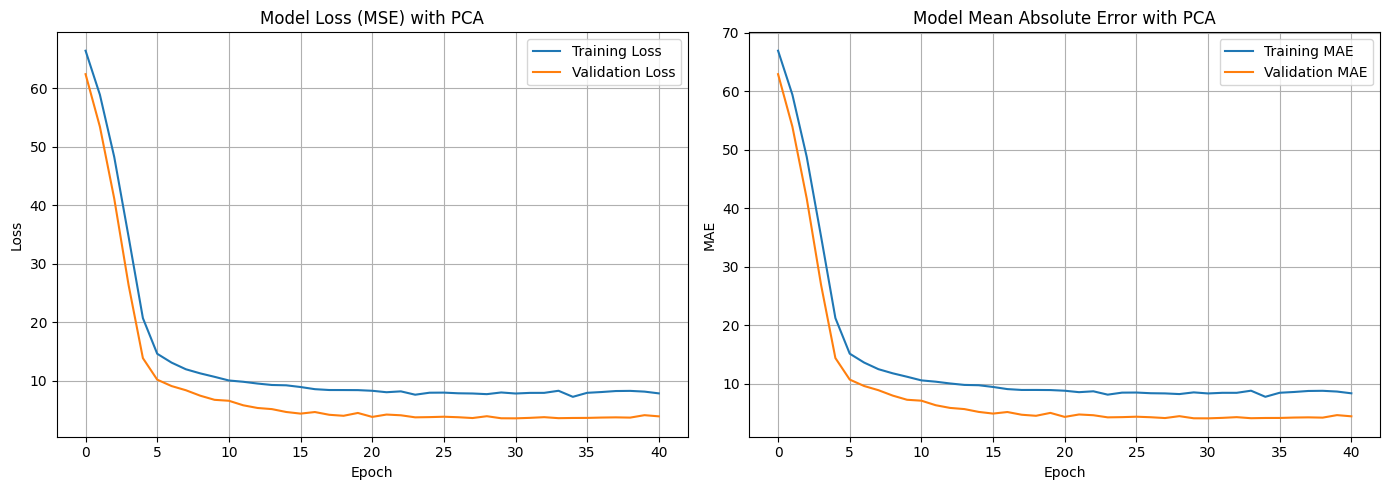

In [22]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_pca.history['loss'], label='Training Loss')
plt.plot(history_pca.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE) with PCA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_pca.history['mae'], label='Training MAE')
plt.plot(history_pca.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error with PCA')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()